In [1]:
%matplotlib inline

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque
import cv2
import matplotlib.pyplot as plt
import os

In [3]:
!wget -P . http://www.atarimania.com/roms/Roms.rar
!unrar e ./Roms.rar
!unzip ROMS.zip
!python -m atari_py.import_roms ./ROMS

--2021-07-08 06:28:19--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘./Roms.rar’

Roms.rar            100%[===================>]  10.61M   471KB/s    in 24s     

2021-07-08 06:28:44 (455 KB/s) - ‘./Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from ./Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
Archive:  ROMS.zip
   creating: ROMS/
  inflating: ROMS/128 in 1 Game Select ROM (128 in 1) (Unknown) ~.bin  
  inflating: ROMS/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) (PAL).bin  


In [ ]:
def plot_learning_curve(x, scores, epsilons, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)
    plt.show()

In [5]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [6]:
class RepeatActionAndMaxFrame(gym.Wrapper):
    def __init__(self, env=None, repeat=4, clip_reward=False, no_ops=0,
                 fire_first=False):
        super(RepeatActionAndMaxFrame, self).__init__(env)
        self.repeat = repeat
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))
        self.clip_reward = clip_reward
        self.no_ops = no_ops
        self.fire_first = fire_first

    def step(self, action):
        t_reward = 0.0
        done = False
        for i in range(self.repeat):
            obs, reward, done, info = self.env.step(action)
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]
            t_reward += reward
            idx = i % 2
            self.frame_buffer[idx] = obs
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1])
        return max_frame, t_reward, done, info

    def reset(self):
        obs = self.env.reset()
        no_ops = np.random.randint(self.no_ops)+1 if self.no_ops > 0 else 0
        for _ in range(no_ops):
            _, _, done, _ = self.env.step(0)
            if done:
                self.env.reset()
        if self.fire_first:
            assert self.env.unwrapped.get_action_meanings()[1] == 'FIRE'
            obs, _, _, _ = self.env.step(1)

        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = obs

        return obs

In [7]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, shape, env=None):
        super(PreprocessFrame, self).__init__(env)
        self.shape = (shape[2], shape[0], shape[1])
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0,
                                    shape=self.shape, dtype=np.float32)

    def observation(self, obs):
        new_frame = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized_screen = cv2.resize(new_frame, self.shape[1:],
                                    interpolation=cv2.INTER_AREA)
        new_obs = np.array(resized_screen, dtype=np.uint8).reshape(self.shape)
        new_obs = new_obs / 255.0

        return new_obs

In [8]:
class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        self.observation_space = gym.spaces.Box(
                            env.observation_space.low.repeat(repeat, axis=0),
                            env.observation_space.high.repeat(repeat, axis=0),
                            dtype=np.float32)
        self.stack = deque(maxlen=repeat)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

In [9]:
def make_env(env_name, shape=(84,84,1), repeat=4, clip_rewards=False,
             no_ops=0, fire_first=False):
    env = gym.make(env_name)
    env = RepeatActionAndMaxFrame(env, repeat, clip_rewards, no_ops, fire_first)
    env = PreprocessFrame(shape, env)
    env = StackFrames(env, repeat)

    return env

In [10]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, name)

        self.conv1 = nn.Conv2d(input_dims[0], 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)

        fc_input_dims = self.calculate_conv_output_dims(input_dims)

        self.fc1 = nn.Linear(fc_input_dims, 512)
        self.fc2 = nn.Linear(512, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)

        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def calculate_conv_output_dims(self, input_dims):
        state = torch.zeros(1, *input_dims)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, state):
        conv1 = F.relu(self.conv1(state))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        # conv3 shape is BS x n_filters x H x W
        conv_state = conv3.view(conv3.size()[0], -1)
        # conv_state shape is BS x (n_filters * H * W)
        flat1 = F.relu(self.fc1(conv_state))
        actions = self.fc2(flat1)

        return actions

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

In [11]:
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = torch.tensor([observation],dtype=torch.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = torch.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = torch.tensor(state).to(self.q_eval.device)
        rewards = torch.tensor(reward).to(self.q_eval.device)
        dones = torch.tensor(done).to(self.q_eval.device)
        actions = torch.tensor(action).to(self.q_eval.device)
        states_ = torch.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[:, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.decrement_epsilon()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


episode:  0 score:  -20.0  average score -20.0 best score -inf epsilon 0.99 steps 871
... saving checkpoint ...
... saving checkpoint ...


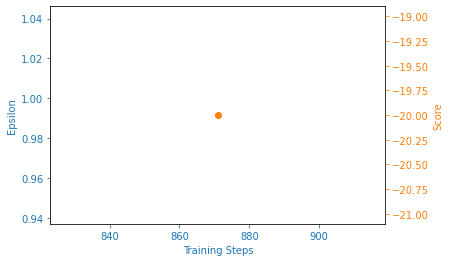

episode:  1 score:  -21.0  average score -20.5 best score -20.00 epsilon 0.98 steps 1849


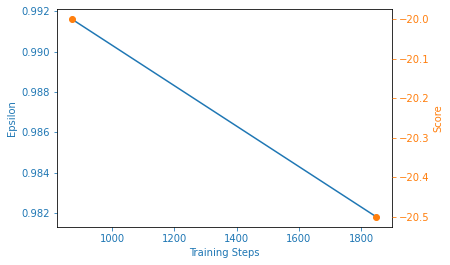

episode:  2 score:  -21.0  average score -20.7 best score -20.00 epsilon 0.97 steps 2821


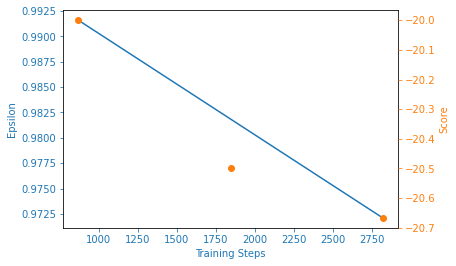

episode:  3 score:  -19.0  average score -20.2 best score -20.00 epsilon 0.96 steps 3819


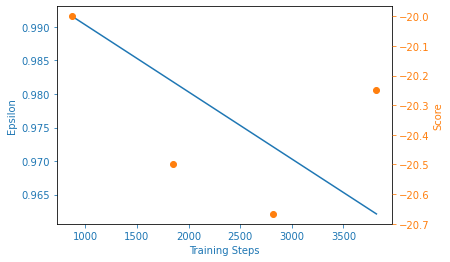

episode:  4 score:  -20.0  average score -20.2 best score -20.00 epsilon 0.95 steps 4751


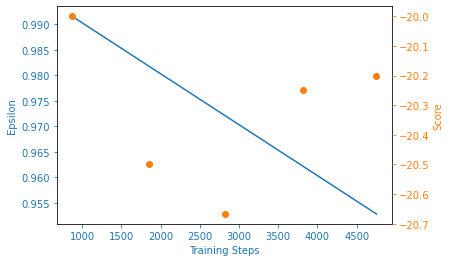

episode:  5 score:  -20.0  average score -20.2 best score -20.00 epsilon 0.94 steps 5731


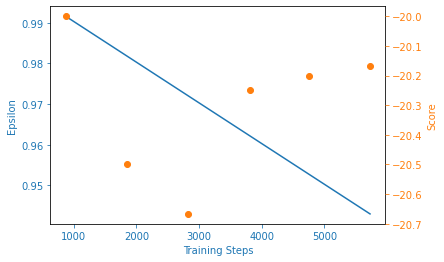

episode:  6 score:  -20.0  average score -20.1 best score -20.00 epsilon 0.93 steps 6650


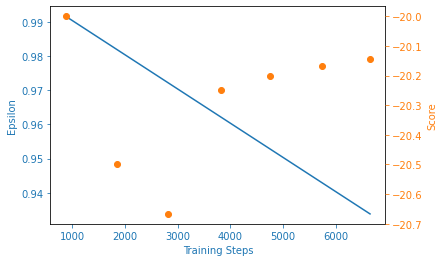

episode:  7 score:  -21.0  average score -20.2 best score -20.00 epsilon 0.92 steps 7550


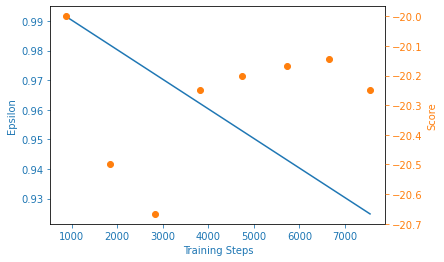

episode:  8 score:  -21.0  average score -20.3 best score -20.00 epsilon 0.92 steps 8314


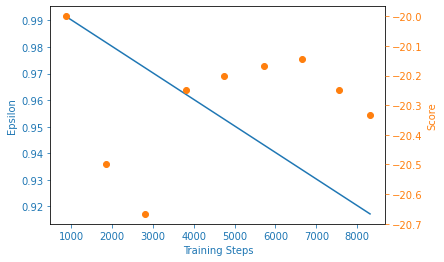

episode:  9 score:  -19.0  average score -20.2 best score -20.00 epsilon 0.91 steps 9511


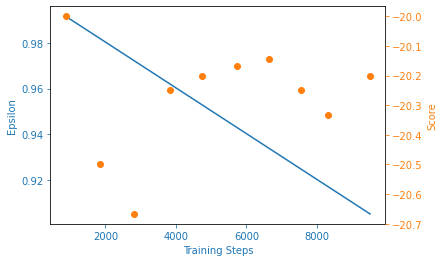

episode:  10 score:  -20.0  average score -20.2 best score -20.00 epsilon 0.90 steps 10499


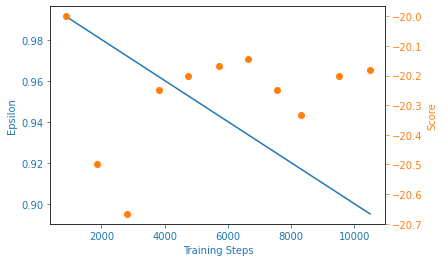

episode:  11 score:  -18.0  average score -20.0 best score -20.00 epsilon 0.88 steps 11862


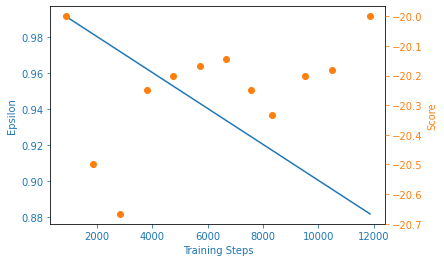

episode:  12 score:  -21.0  average score -20.1 best score -20.00 epsilon 0.87 steps 12854


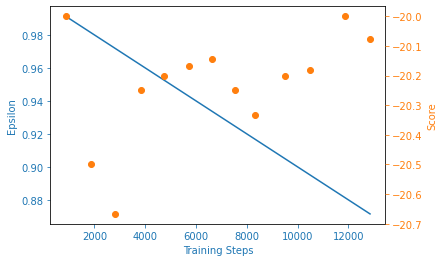

episode:  13 score:  -21.0  average score -20.1 best score -20.00 epsilon 0.86 steps 13618


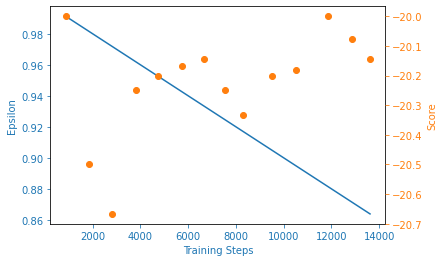

episode:  14 score:  -19.0  average score -20.1 best score -20.00 epsilon 0.85 steps 14703


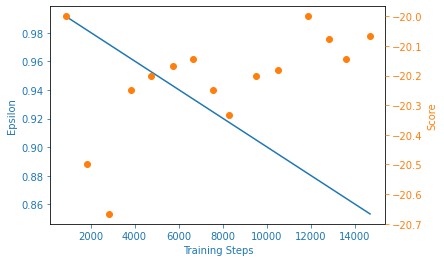

KeyboardInterrupt: ignored

In [12]:
env = make_env('PongNoFrameskip-v4')
best_score = -np.inf
load_checkpoint = False
n_games = 1

agent = DQNAgent(gamma=0.99, epsilon=1, lr=0.0001,
                     input_dims=(env.observation_space.shape),
                     n_actions=env.action_space.n, mem_size=20000, eps_min=0.1,
                     batch_size=32, replace=1000, eps_dec=1e-5,
                     chkpt_dir='./', algo='DQNAgent',
                     env_name='PongNoFrameskip-v4')

if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) + '_' + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'
# if you want to record video of your agent playing, do a mkdir tmp && mkdir tmp/dqn-video
# and uncomment the following 2 lines.
# env = wrappers.Monitor(env, "tmp/dqn-video",
#                    video_callable=lambda episode_id: True, force=True)
n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action, reward, observation_, done)
            agent.learn()
            observation = observation_
            n_steps += 1

    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])
    print('episode: ', i,'score: ', score,
        ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
        'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)

    x = [i+1 for i in range(len(scores))]
    plot_learning_curve(steps_array, scores, eps_history)